In [66]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
backend nbAgg version unknown
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [195]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A point
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    x_length_squared = x[0] ** 2 + x[1] ** 2
    return a * np.exp(-gamma * x_length_squared) - np.exp(-beta * x_length_squared)


In [211]:
class GCN2D(object):
    
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 boostEffect=10,
                 boostDecay=0.2,
                 dt=0.001,
                 numPlaces=200,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                ):
        self.activity = torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow, 1+2*inhibitionWindow], dtype=torch.float)
        self.numX = numX
        self.numY = numY
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                
                self.filter[0, 0, i, j] = w_0(dist/inhibitionRadius)*inhibitionStrength
                
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.boostEffect = boostEffect
        self.boostDecay = boostDecay
        self.dt = dt
        self.globalTonic = globalTonic
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.random.rand(numPlaces, 2), device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces), device=device, dtype=torch.float)
        self.placeWeights /= 10.
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
        envelopeX = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numX)]

        envelopeY = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numY)]

        return np.outer(envelopeX, envelopeY)


        
    def step(self):        
        self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
        self.instantaneous += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous += self.boostEffect * self.activationHistory
        self.instantaneous *= self.envelope
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        self.activationHistory += ((torch.mean(self.activity) - self.activity)*(self.boostDecay) +\
                                (1. - self.boostDecay)*self.activationHistory)*self.envelope
        
        
    def simulate(self, time,logFreq = 100.):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY), device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(numSteps/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device="cpu")
        
        for t in xrange(numSteps):
            self.step()
            if t % logFreq == 0:
                s = int(t/logFreq)
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                
        return output.numpy()
    
    def learn(self, time):  
        self.activityBuffer = torch.zeros([self.stdpWindow, 1, self.numX, self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        trajectory = np.zeros((len(times), 2))
        trajectory[:, 0] = (np.sin(dir * (runTimes * np.pi / (5 / speed) - np.pi / 2.)) + 1) * \
                           2.5 + startingPoint
        trajectory[:, 1] = (np.sin(dir * (runTimes * np.pi / (5 / speed) - np.pi / 2.)) + 1) * \
                           2.5        
        
    def stdpUpdate(self, time, clearBuffer=False):
        if self.bufferIndex < self.stdpBuffer.shape[0]:
            self.stdpBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.sdtpWindow):
                i = t + self.bufferIndex % self.stdpWindow            
                self.placeWeights += torch.ger(self.placeBuffer[i],
                                               self.activity.view(self.numX*self.numY))* \
                                        self.stdpValues[t]
                self.placeWeights -= torch.ger(self.placeActivity, self.activityBuffer[i]) *\
                                        self.stdpValues[t]
                
            self.bufferIndex += 1
            self.stdpBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:

<IPython.core.display.Javascript object>


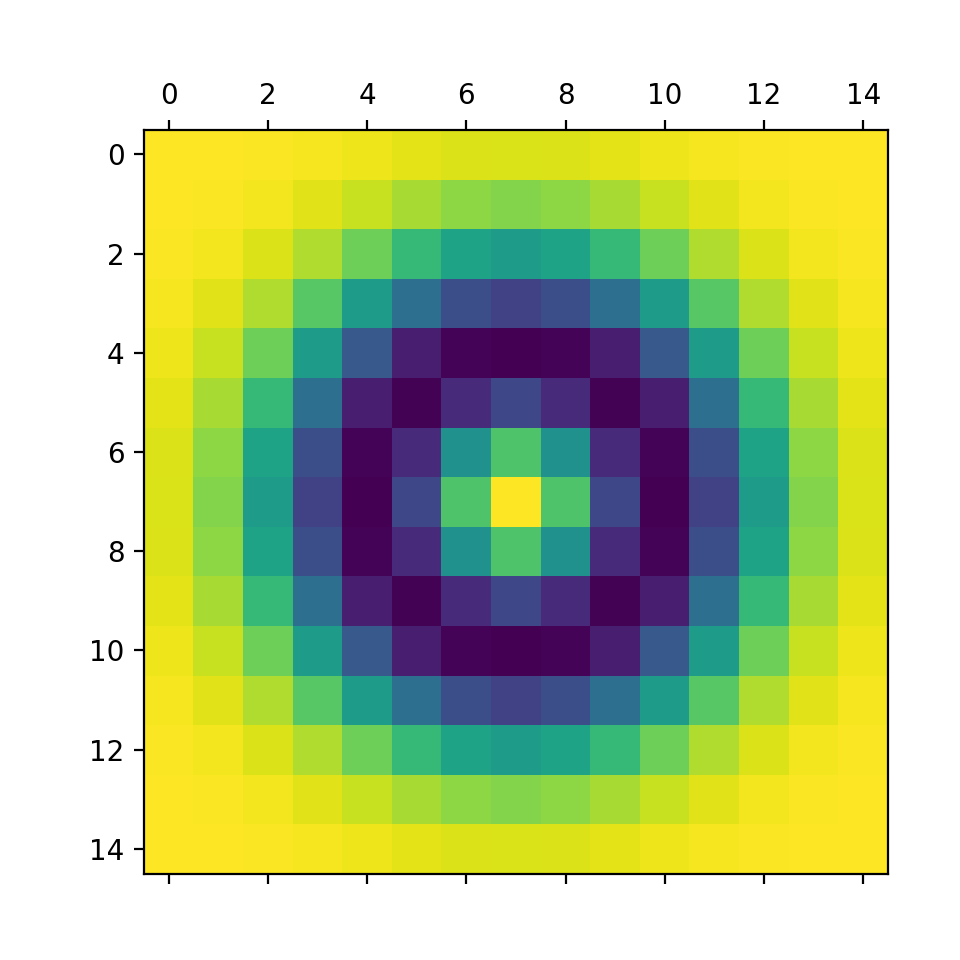

In [212]:
GCN = GCN2D(64, 64, 7, .4, 1000, globalTonic=100, dt=0.01, boostEffect=1, boostDecay=1)
plt.matshow(GCN.filter[0,0])
plt.show()

At 0.0
At 1.0
At 2.0
At 3.0
At 4.0
At 5.0
At 6.0
At 7.0
At 8.0
At 9.0
At 10.0
At 11.0
At 12.0
At 13.0
At 14.0
At 15.0
At 16.0
At 17.0
At 18.0
At 19.0
At 20.0
At 21.0
At 22.0
At 23.0
At 24.0
At 25.0
At 26.0
At 27.0
At 28.0
At 29.0
At 30.0
At 31.0
At 32.0
At 33.0
At 34.0
At 35.0
At 36.0
At 37.0
At 38.0
At 39.0
At 40.0
At 41.0
At 42.0
At 43.0
At 44.0
At 45.0
At 46.0
At 47.0
At 48.0
At 49.0
At 50.0
At 51.0
At 52.0
At 53.0
At 54.0
At 55.0
At 56.0
At 57.0
At 58.0
At 59.0
At 60.0
At 61.0
At 62.0
At 63.0
At 64.0
At 65.0
At 66.0
At 67.0
At 68.0
At 69.0
At 70.0
At 71.0
At 72.0
At 73.0
At 74.0
At 75.0
At 76.0
At 77.0
At 78.0
At 79.0
At 80.0
At 81.0
At 82.0
At 83.0
At 84.0
At 85.0
At 86.0
At 87.0
At 88.0
At 89.0
At 90.0
At 91.0
At 92.0
At 93.0
At 94.0
At 95.0
At 96.0
At 97.0
At 98.0
At 99.0


<IPython.core.display.Javascript object>


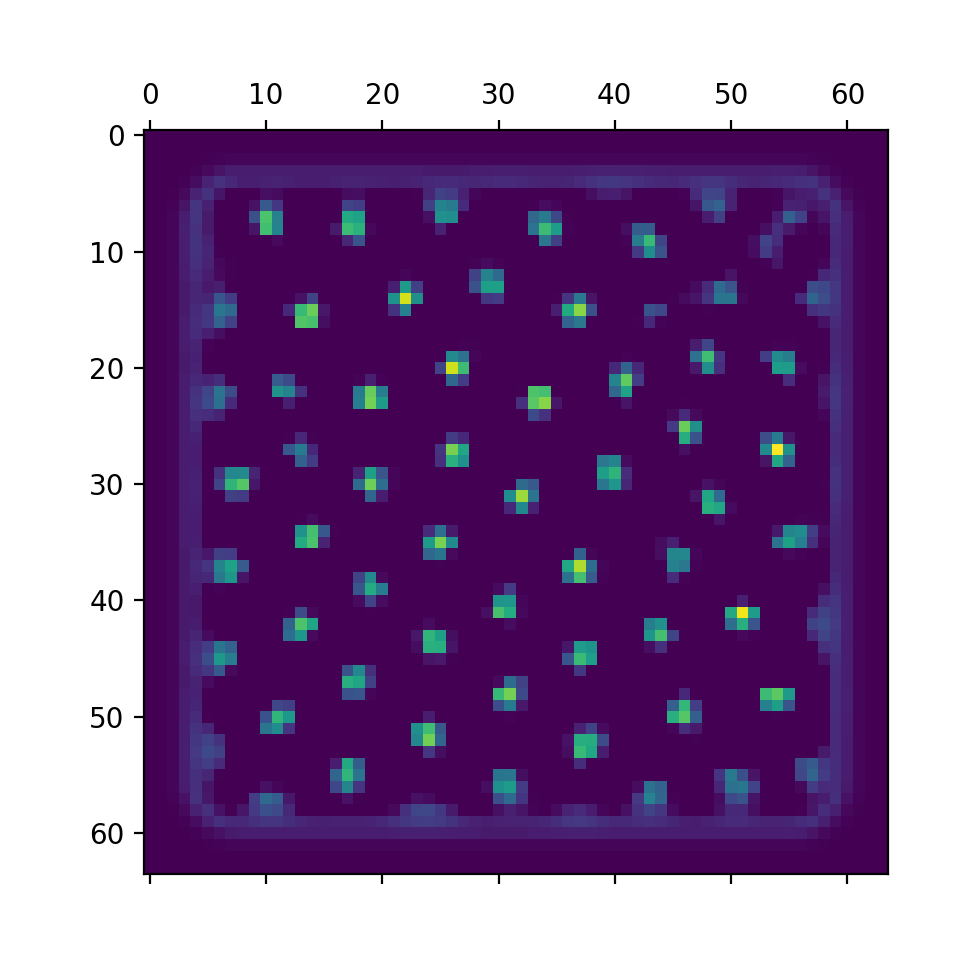

In [213]:
results = GCN.simulate(100)
plt.matshow(results[-1])
plt.show()

In [216]:
animation.verbose.set_level("helpful")
def createMovie(data, name):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,

    fig = plt.figure()

    l = plt.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, len(data), fargs=(data, l),
                                  interval=100, blit=True)

    ani.save(name+'.mp4')

<IPython.core.display.Javascript object>


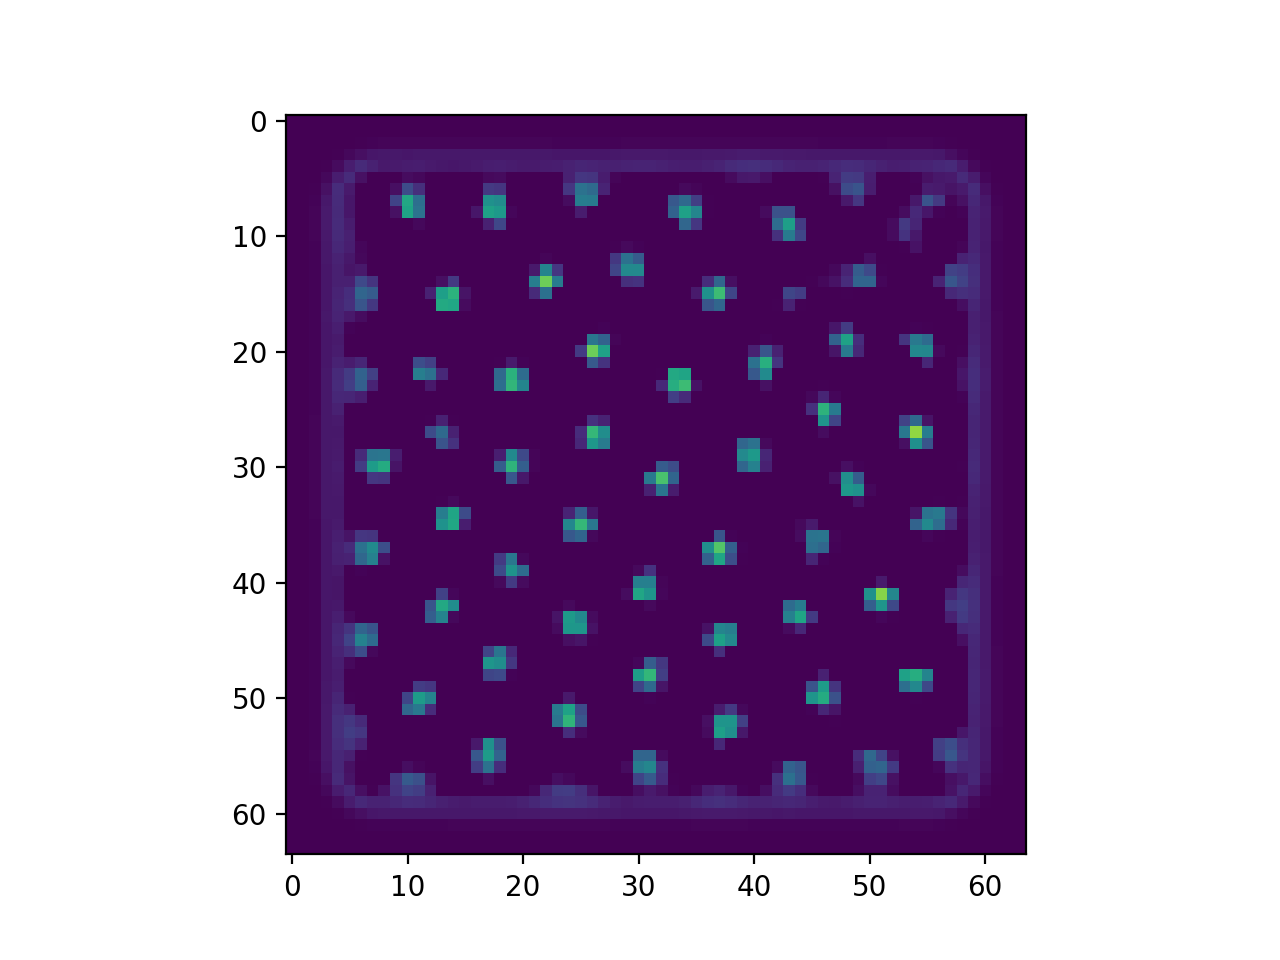

Animation.save using <class 'matplotlib.animation.ImageMagickFileWriter'>
MovieWriter.run: running command: convert -delay 10.0 -loop 0 _tmp*.png test.mp4


In [217]:
createMovie(results, "test")